In [1]:
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.diagnostic import linear_rainbow, het_breuschpagan
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import LabelEncoder

In [2]:
df = pd.read_csv(os.path.join("data", "cars.csv"))

In [3]:
df.head()

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 301 entries, 0 to 300
Data columns (total 9 columns):
Car_Name         301 non-null object
Year             301 non-null int64
Selling_Price    301 non-null float64
Present_Price    301 non-null float64
Kms_Driven       301 non-null int64
Fuel_Type        301 non-null object
Seller_Type      301 non-null object
Transmission     301 non-null object
Owner            301 non-null int64
dtypes: float64(2), int64(3), object(4)
memory usage: 21.3+ KB


In [5]:
df.describe()

,Year,Selling_Price,Present_Price,Kms_Driven,Owner
count,301.000000,301.000000,301.000000,301.000000,301.000000
mean,2013.627907,4.661296,7.628472,36947.205980,0.043189
std,2.891554,5.082812,8.644115,38886.883882,0.247915
min,2003.000000,0.100000,0.320000,500.000000,0.000000
25%,2012.000000,0.900000,1.200000,15000.000000,0.000000
50%,2014.000000,3.600000,6.400000,32000.000000,0.000000
75%,2016.000000,6.000000,9.900000,48767.000000,0.000000
max,2018.000000,35.000000,92.600000,500000.000000,3.000000


In [6]:
df.columns

Index(['Car_Name', 'Year', 'Selling_Price', 'Present_Price', 'Kms_Driven',
       'Fuel_Type', 'Seller_Type', 'Transmission', 'Owner'],
      dtype='object')

In [7]:
# reorder so present_price is the first column
cols = list(df.columns)
cols = [cols[3]] + cols[:3] + cols[4:]
df = df[cols]
df.head()

,Present_Price,Car_Name,Year,Selling_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,5.59,ritz,2014,3.35,27000,Petrol,Dealer,Manual,0
1,9.54,sx4,2013,4.75,43000,Diesel,Dealer,Manual,0
2,9.85,ciaz,2017,7.25,6900,Petrol,Dealer,Manual,0
3,4.15,wagon r,2011,2.85,5200,Petrol,Dealer,Manual,0
4,6.87,swift,2014,4.60,42450,Diesel,Dealer,Manual,0


In [35]:
discrete = ['Year', 'Owner']
continuous = ['Present_Price', 'Selling_Price','Kms_Driven']
categorical = ['Fuel_Type', 'Seller_Type', 'Transmission']

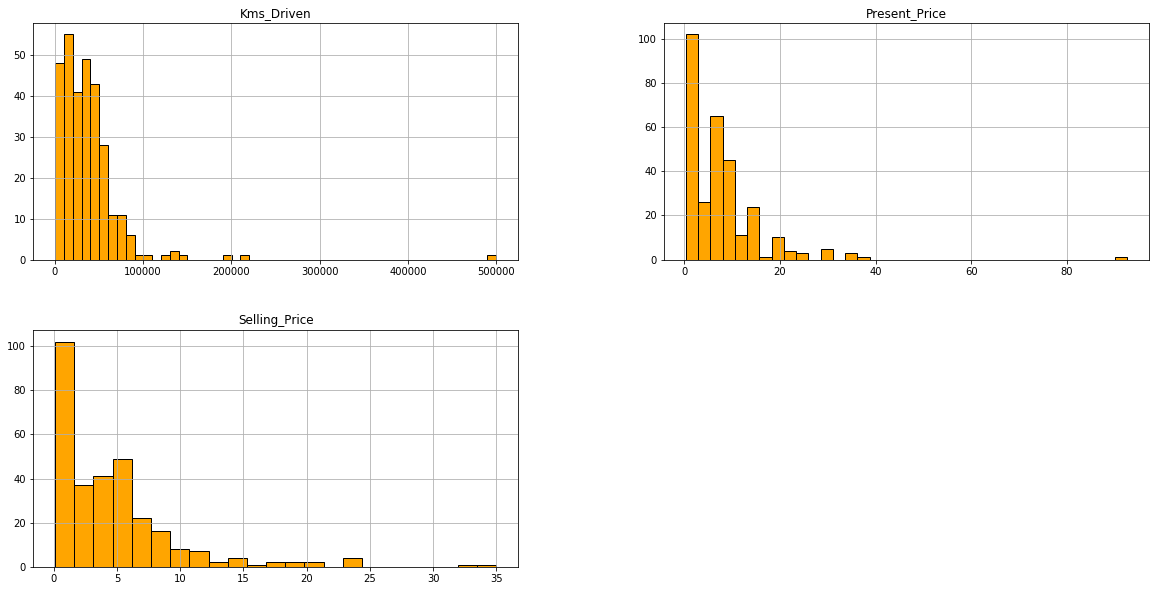

In [36]:
df[continuous].hist(figsize=(20,10), color='orange', edgecolor='black', bins='auto');

All 4 columns seem to be skewed:
- `Kms_Driven`, `Selling_Price` - skewed right
- `Year` - skewed left
--> We can try to apply log transformation to make them more normally distributed

In [12]:
# Create a function for log transformation that prefixes 'log_' to column names
def log_transform(cols, dt):
    output = pd.DataFrame([])
    for c in cols:  
        output[f'log_{c}'] = np.log(dt[c])
    return output

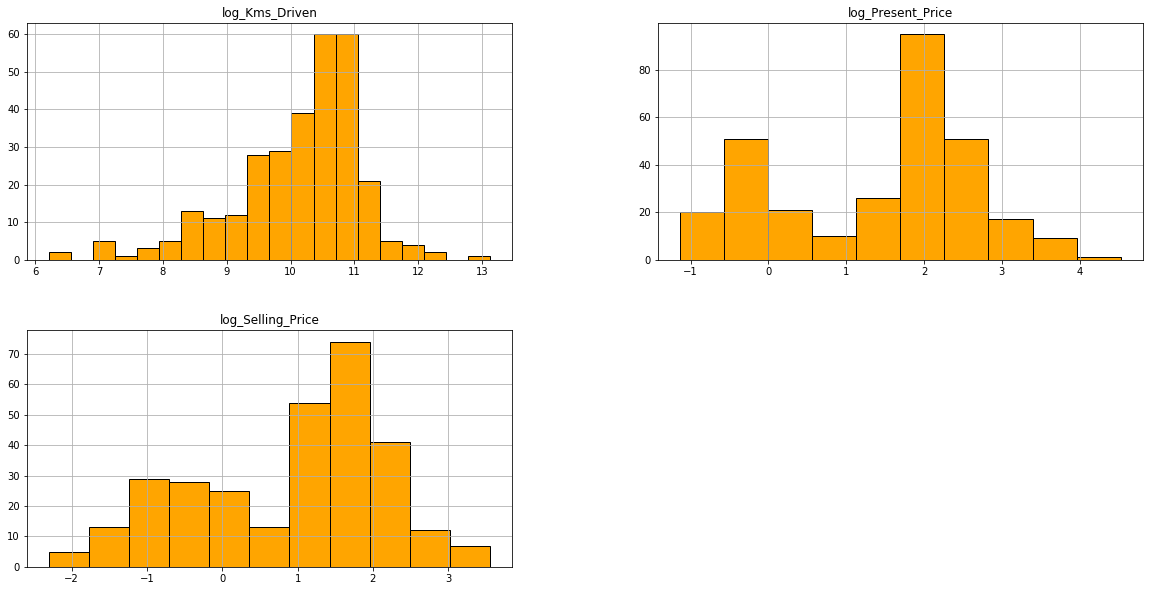

In [37]:
log_cont = log_transform(continuous, df)
log_cont.hist(figsize=(20,10), color='orange', edgecolor='black', bins='auto');

`log_Selling_Price` does NOT look very normal

Try Inversing to see if they look any better

In [14]:
def inverse(cols, dt):
    output = pd.DataFrame([])
    for c in cols:  
        output[f'inv_{c}'] = 1/dt[c]
    return output

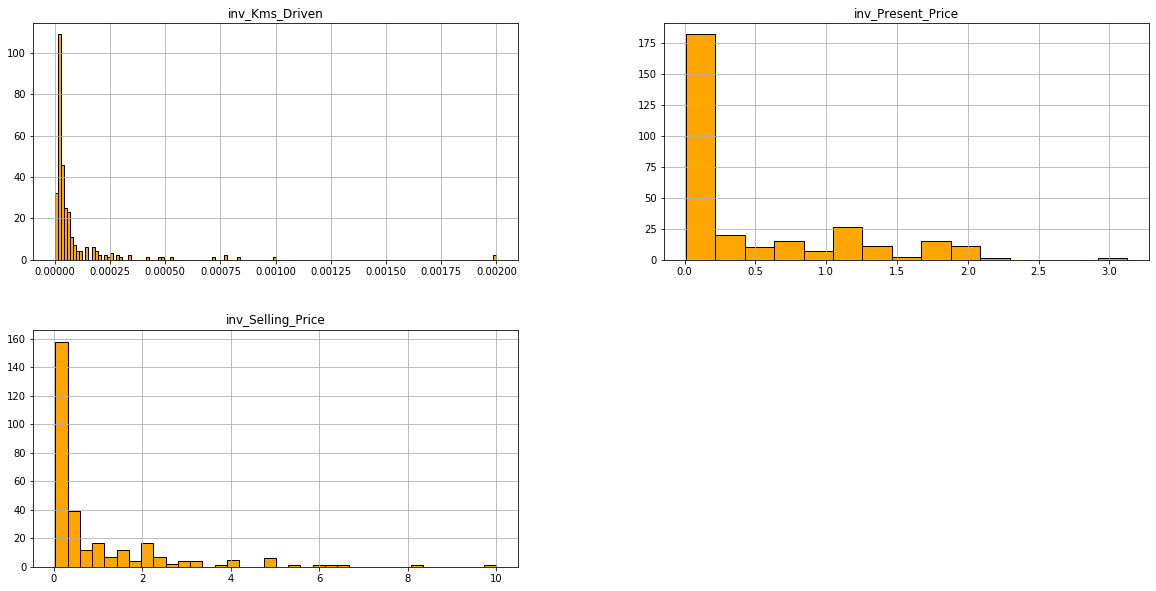

In [38]:
inverse(continuous, df).hist(figsize=(20,10), color='orange', edgecolor='black', bins='auto');

Inversing does not look better than log transformation -> scratch that

Try getting the square root next:

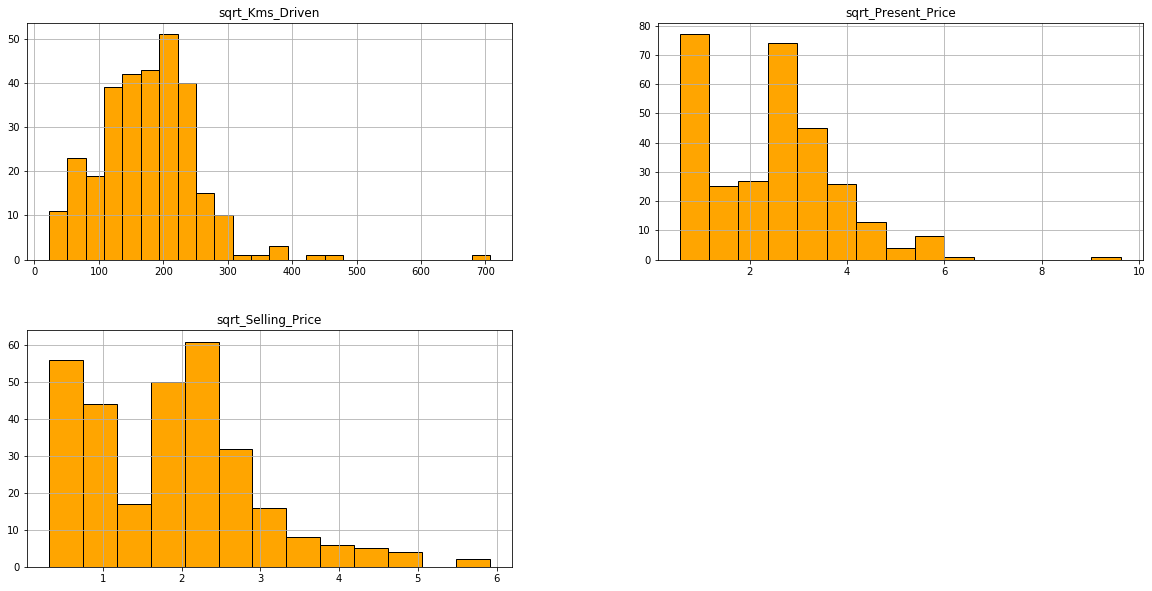

In [39]:
def sq_rt(cols, dt):
    output = pd.DataFrame([])
    for c in cols:  
        output[f'sqrt_{c}'] = (dt[c])**.5
    return output
sq_rt(continuous, df).hist(figsize=(20,10), color='orange', edgecolor='black', bins='auto');

`sqrt_Selling_Price` still does not look normal after we use the square root transformation

Among the 3, the results after log transformation still looks the best --> we'll proceed with that for now

We can then apply standardization to set mean = 0 and standard deviation = 1

In [17]:
# create standardize function
def standardize(cols, dt):
    output = pd.DataFrame([])
    for c in cols:
        output[f'std_{c}'] = (dt[c] - np.mean(dt[c])) / np.std(dt[c])
    return output

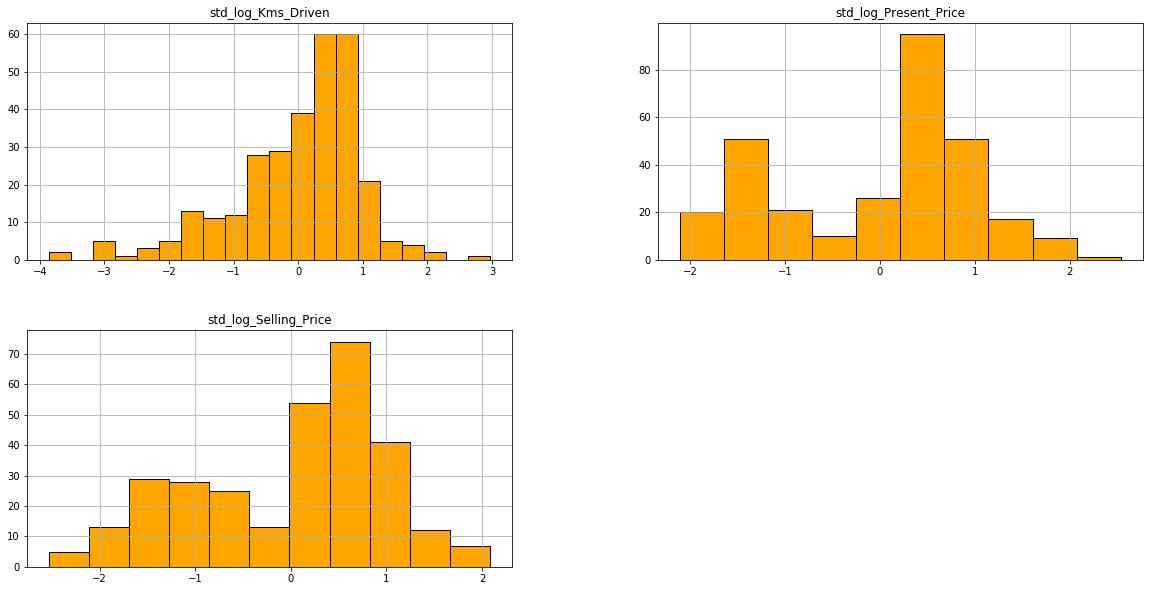

In [40]:
# Apply standardize() on log_cont
final_conts = standardize(log_cont.columns, log_cont)
final_conts.hist(figsize=(20,10), color='orange', edgecolor='black', bins='auto');

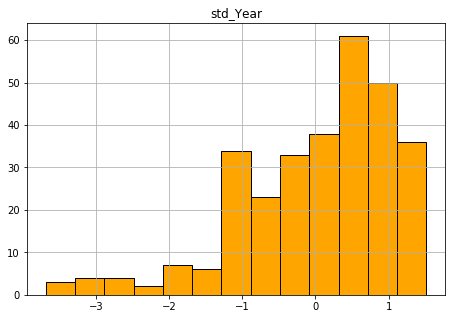

In [18]:
# Apply standardize() on df.Year
final_year = standardize(['Year'], df)
final_year.hist(figsize=(7.5,5), color='orange', edgecolor='black', bins='auto');

I decided to keep `df.Owner` as it is because its values [1,2,3] are already relatively close to the other columns after transformations. 

Honestly, I'm not 100% sure if I should process `Owner` as categorical or discrete...

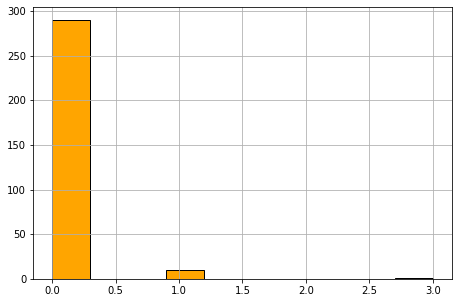

In [19]:
df.Owner.hist(figsize=(7.5,5), color='orange', edgecolor='black', bins='auto');

In [41]:
preprocessed1 = pd.concat([final_conts, final_year, df.Owner], axis=1)
preprocessed1.head()

,std_log_Present_Price,std_log_Selling_Price,std_log_Kms_Driven,std_Year,Owner
0,0.236198,0.234419,0.083911,0.128897,0
1,0.674460,0.509468,0.543824,-0.217514,0
2,0.700680,0.842549,-1.264426,1.168129,0
3,-0.008035,0.107095,-1.543976,-0.910335,0
4,0.405254,0.484193,0.531102,0.128897,0


## Data Understanding

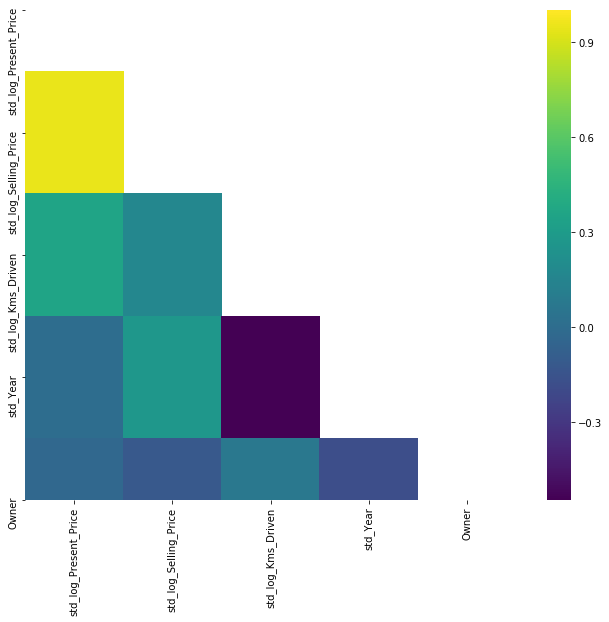

In [42]:
corr = preprocessed1.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))

fig1, ax1 = plt.subplots(figsize=(11,9))
sns.heatmap(corr, mask=mask, ax=ax1, cmap="viridis");

- Features that seem to be **positively correlated** to `std_log_Present_Price` are `Selling_Price` and `Kms_Driven`, and `Owner`

- Feature that seem to be **negatively correlated** to `std_log_Present_Price` is `Year`

In [43]:
corr

,std_log_Present_Price,std_log_Selling_Price,std_log_Kms_Driven,std_Year,Owner
std_log_Present_Price,1.000000,0.949679,0.357346,-0.000359,-0.027322
std_log_Selling_Price,0.949679,1.000000,0.170268,0.272282,-0.117410
std_log_Kms_Driven,0.357346,0.170268,1.000000,-0.545249,0.074260
std_Year,-0.000359,0.272282,-0.545249,1.000000,-0.182104
Owner,-0.027322,-0.117410,0.074260,-0.182104,1.000000


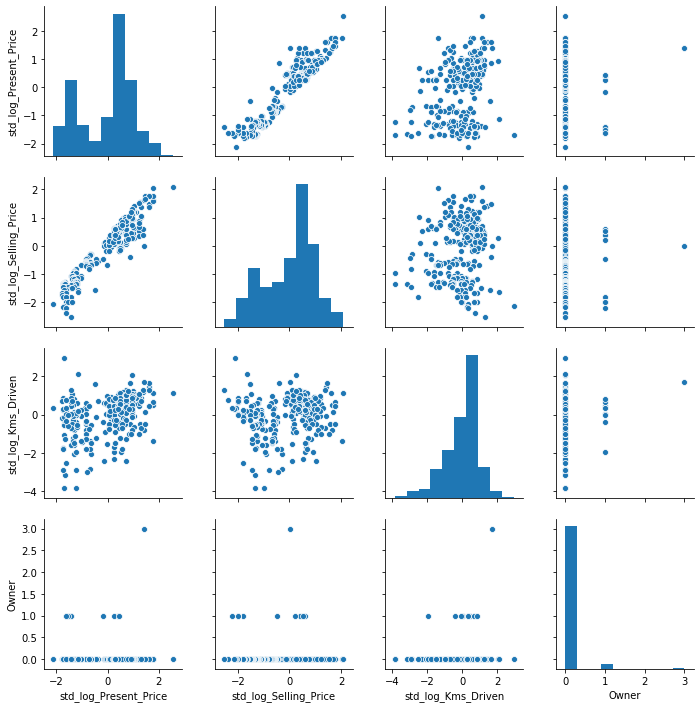

In [45]:
positively_correlated_cols = ['std_log_Present_Price', 'std_log_Selling_Price', 'std_log_Kms_Driven', 'Owner']
positively_correlated_df = preprocessed1[positively_correlated_cols]
sns.pairplot(positively_correlated_df);

## First Simple Model

In [46]:
sm_df1 = preprocessed1[['std_log_Present_Price', 'std_log_Selling_Price']].copy()

In [67]:
def create_formula(data):
    output = 'std_log_Present_Price'
    predictors = data.drop(output, axis=1).columns
    pred_sum = predictors[0] if len(predictors) == 1 else '+'.join(predictors)
    formula = output + '~' + pred_sum
    return formula

In [68]:
f = create_formula(sm_df1)
f

'std_log_Present_Price~std_log_Selling_Price'

In [69]:
sm_1 = ols(formula=f, data=sm_df1).fit()
sm_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     std_log_Present_Price   R-squared:                       0.902
Model:                               OLS   Adj. R-squared:                  0.902
Method:                    Least Squares   F-statistic:                     2749.
Date:                   Tue, 16 Feb 2021   Prob (F-statistic):          8.86e-153
Time:                           15:35:16   Log-Likelihood:                -77.690
No. Observations:                    301   AIC:                             159.4
Df Residuals:                        299   BIC:                             166.8
Df Model:                              1                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.771e-16      0.018   9.77e-15      1.000      -0.036       0.036
std_log_Selling_Price     0.9497      0.018     52.427      0.000       0.914       0.985
==============================================================================
Omnibus:                       76.822   Durbin-Watson:                   1.274
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              154.092
Skew:                           1.315   Prob(JB):                     3.46e-34
Kurtosis:                       5.317   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
int(1.771e-16)

0

We're explaining about 90.2% of the variability of `std_log_Present_Price`, but we only have 1 feature so far, and it's statistically significant at alpha = 0.05

With our current model:
- A car with a standardized log-transformed Selling Price of 0 would have a `std_log_Present_Price` value of 1.771e-16, which is very close to 0.
- And with an increase of 1 "unit" in std_log_Selling_Price, the `std_log_Present_Price` value would increase by 0.9497

### Check Linear Regression Assumptions

In [108]:
def check_assumptions(model, df):  
    print('\t\t\t\t\tStatistic \tP-value')
    # Linearity (using Rainbow Test)
    rainbow_statistic, rainbow_p_value = linear_rainbow(model)
    print(f'(Linearity) Rainbow Test \t\t{round(rainbow_statistic,3)} \t\t{round(rainbow_p_value,3)}')
    
    # Normality (using Jarque-Bera)
    residuals = model.resid
    jb = jarque_bera(residuals, axis=0)
    jb_statistic, jb_p_value = jb[:2]
    print(f'(Normality) Jarque-Bera Test \t\t{round(jb_statistic,3)} \t{round(jb_p_value,3)}')
    print()
    # Homoskedasticity (using Breusch-Pagan test)
    y = df.std_log_Present_Price
    y_hat = model.predict()
    print('\t\t\t\t\tLagrange Multiplier p-value \tF-statistic p-value')
    lm, lm_p_value, fvalue, f_p_value = het_breuschpagan(y-y_hat, df[["std_log_Selling_Price"]])
    print(f'(Homoskedasticity) Breusch-Pagan test \t{round(lm_p_value,3)} \t\t\t\t{round(f_p_value,3)}')
    
    # Plot residuals to check for homoskedasticity
    fig2, ax2 = plt.subplots()
    ax2.set(xlabel='Predicted Standardized Log Transformed Present Price',
            ylabel='Residuals (Predicted - Actual Standardized \nLog Transformed Present Price)')
    ax2.axhline(y=0, xmin=y_hat.min(), xmax=y_hat.max(), color='red', lw=0.5)
    ax2.scatter(x=y_hat, y=y_hat-y, color='blue', alpha=0.2);

					Statistic 	P-value
(Linearity) Rainbow Test 		0.534 		1.0
(Normality) Jarque-Bera Test 		154.092 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.035


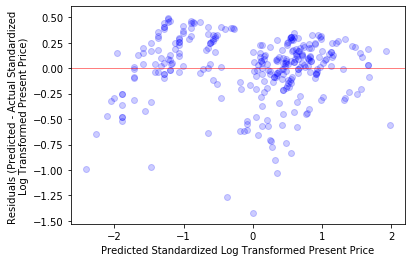

In [109]:
check_assumptions(sm_1, sm_df1)

#### Linearity (using Rainbow Test)

p-value is really high --> fail to reject the Null Hypothesis (H_0 is that the model is linearly predicted by the feature)

--> Satisfy the Linearity Assumption

#### Normality (using Jarque-Bera)

H_0: residuals are normally distributed

H_A: residuals are not normally distributed

p_value is 0 (< 0.05) --> reject H_0
--> Violate Normality Assumption

#### Homoskedasticity

Visualization

Visually, the residuals look pretty good, although it seems like the errors are more dense above 0 (overestimated), and underestimated errors could be quite large. 

Using Breusch-Pagan test 

H_0: Homoskedasticity

H_A: Heteroskedasticity

p-value < 0.05 --> reject H_0
--> Violate the Homoskedasticity Assumption

### Add A Categorical Value

In [57]:
for c in ['Fuel_Type', 'Seller_Type', 'Transmission', 'Owner']:
    print(df[c].value_counts())
    print()

Petrol    239
Diesel     60
CNG         2
Name: Fuel_Type, dtype: int64

Dealer        195
Individual    106
Name: Seller_Type, dtype: int64

Manual       261
Automatic     40
Name: Transmission, dtype: int64

0    290
1     10
3      1
Name: Owner, dtype: int64



I am going to pick `Seller_Type` because the 2 types `Dealer` and `Individual` seems more evenly distributed than other categorical columns

In [59]:
sm_df2 = pd.concat([sm_df1, df.Seller_Type], axis=1)
sm_df2.head()

,std_log_Present_Price,std_log_Selling_Price,Seller_Type
0,0.236198,0.234419,Dealer
1,0.674460,0.509468,Dealer
2,0.700680,0.842549,Dealer
3,-0.008035,0.107095,Dealer
4,0.405254,0.484193,Dealer


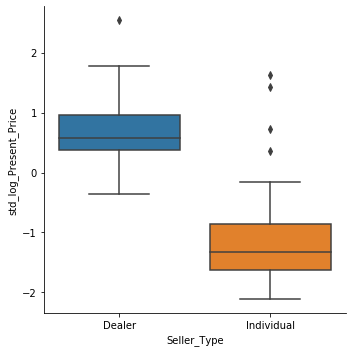

In [60]:
sns.catplot(x='Seller_Type', y='std_log_Present_Price', data=sm_df2, kind='box');

In [ ]:
label_encoder = LabelEncoder()
seller_lb_fit = label_encoder.fit(sm_df2.Seller_Type)
seller_labels = seller_lb_fit.transform(sm_df2.Seller_Type)

In [64]:
label_encoder.classes_

array(['Dealer', 'Individual'], dtype=object)

In [66]:
sm_df2['encoded_seller'] = seller_labels
sm_df2.drop('Seller_Type', axis=1, inplace=True)
sm_df2.head()

,std_log_Present_Price,std_log_Selling_Price,encoded_seller
0,0.236198,0.234419,0
1,0.674460,0.509468,0
2,0.700680,0.842549,0
3,-0.008035,0.107095,0
4,0.405254,0.484193,0


In [72]:
f = create_formula(sm_df2)
f

'std_log_Present_Price~std_log_Selling_Price+encoded_seller'

In [73]:
sm_2 = ols(formula=f, data=sm_df2).fit()
sm_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     std_log_Present_Price   R-squared:                       0.915
Model:                               OLS   Adj. R-squared:                  0.914
Method:                    Least Squares   F-statistic:                     1596.
Date:                   Tue, 16 Feb 2021   Prob (F-statistic):          5.89e-160
Time:                           15:37:34   Log-Likelihood:                -56.770
No. Observations:                    301   AIC:                             119.5
Df Residuals:                        298   BIC:                             130.7
Df Model:                              2                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.1587      0.029      5.433      0.000       0.101       0.216
std_log_Selling_Price     0.7663      0.032     23.731      0.000       0.703       0.830
encoded_seller           -0.4507      0.068     -6.666      0.000      -0.584      -0.318
==============================================================================
Omnibus:                      115.805   Durbin-Watson:                   1.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              404.037
Skew:                           1.678   Prob(JB):                     1.84e-88
Kurtosis:                       7.577   Cond. No.                         5.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Adding information about Seller Type did increase the Adjusted R Squared by 0.012 (from 0.902 to 0.914).

We can look at the Assumptions again:

					Statistic 	P-value
(Linearity) Rainbow Test 		0.67 		0.993
(Normality) Jarque-Bera Test 		404.037 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.625


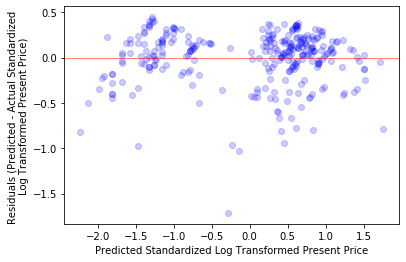

In [110]:
check_assumptions(sm_2, sm_df2)

### Adding `std_log_Kms_Driven` to the model

In [111]:
sm_df3 = pd.concat([sm_df2, preprocessed1.std_log_Kms_Driven], axis=1)
sm_df3.head()

,std_log_Present_Price,std_log_Selling_Price,encoded_seller,std_log_Kms_Driven
0,0.236198,0.234419,0,0.083911
1,0.674460,0.509468,0,0.543824
2,0.700680,0.842549,0,-1.264426
3,-0.008035,0.107095,0,-1.543976
4,0.405254,0.484193,0,0.531102


In [114]:
f3 = create_formula(sm_df3)
f3

'std_log_Present_Price~std_log_Selling_Price+encoded_seller+std_log_Kms_Driven'

In [115]:
sm_3 = ols(formula=f3, data=sm_df3).fit()
sm_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     std_log_Present_Price   R-squared:                       0.944
Model:                               OLS   Adj. R-squared:                  0.943
Method:                    Least Squares   F-statistic:                     1656.
Date:                   Tue, 16 Feb 2021   Prob (F-statistic):          4.96e-185
Time:                           16:08:22   Log-Likelihood:                 5.6219
No. Observations:                    301   AIC:                            -3.244
Df Residuals:                        297   BIC:                             11.58
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.0716      0.025      2.886      0.004       0.023       0.120
std_log_Selling_Price     0.8357      0.027     31.084      0.000       0.783       0.889
encoded_seller           -0.2033      0.059     -3.470      0.001      -0.319      -0.088
std_log_Kms_Driven        0.1838      0.015     12.352      0.000       0.155       0.213
==============================================================================
Omnibus:                       69.208   Durbin-Watson:                   1.644
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              146.409
Skew:                           1.155   Prob(JB):                     1.61e-32
Kurtosis:                       5.517   Cond. No.                         5.73
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

					Statistic 	P-value
(Linearity) Rainbow Test 		0.544 		1.0
(Normality) Jarque-Bera Test 		146.409 	0.0

					Lagrange Multiplier p-value 	F-statistic p-value
(Homoskedasticity) Breusch-Pagan test 	nan 				0.179


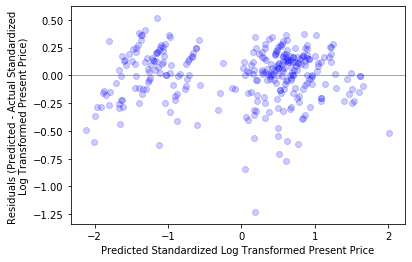

In [116]:
check_assumptions(sm_3, sm_df3)

- Adjusted R2 has increased a little bit more (from 0.914 to 0.943).

- Rainbow Test p-value > 0.05 --> fail to reject Linearity --> satisfy Linearity assumption
- Jarque-Bera Test p-value < 0.05 --> reject Normality --> violate Normality assumption
- Breush-Pagan Test F-statistic p-value > 0.05 --> fail to reject Homoskedasticity --> satisfy Homoskedasticity assumption